# Recourse

In [1]:
#%%
%load_ext autoreload
%autoreload 2

In [ ]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.ticker as ticker
import numpy as np
import logging

from mono_multi.setup import (
    FIGURES_ROOT_DIR,
    PAPER_TASKS
)
from mono_multi.utils import (
    load_model_outputs_same_prompt,
    load_data_if_needed,
    add_evals_to_df,
    load_results_overview,
    # filter_predictions_and_data,
    get_top_models_by_eps,
    filter_results_all_tasks,
    add_newline_camelcase
)
from mono_multi.metrics import (
    get_fraction_no_recourse,
    poisson_binom_agreement,
    get_ambiguity,
    get_discrepancy,
)

from mono_multi.plotting import (
    configure_legend,
    plot_agreement_lineplot,
    plot_recourse_lineplot,
    compute_curves_for_agreement_lineplot,
    compute_curves_for_recourse_lineplot
)


/Users/mgorecki/opt/miniconda3/envs/monoc-py311/lib/python3.11/site-packages/xport/__about__.py:18: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import DistributionNotFound, get_distribution


In [ ]:
plot_config_file = "./results/.matplotlibrc"
plt.rcParams.update(mpl.rc_params_from_file(fname=plot_config_file))

FIGURES_PAPER_DIR = FIGURES_ROOT_DIR / "same-prompt"
TASKS = PAPER_TASKS
IMPRS_POSTER_TASKS = ['ACSIncome', 'ACSEmployment', 'BRFSS_Blood_Pressure', 'SIPP']
print("tasks", TASKS)

tasks ('ACSIncome', 'ACSEmployment', 'BRFSS_Blood_Pressure', 'SIPP', 'ACSTravelTime', 'ACSPublicCoverage', 'ACSMobility')


In [4]:
select_by='accuracy' #'balanced_accuracy' #
fit_threshold_for= 'balanced_accuracy' #'accuracy' #

## Load Task Data

In [5]:
try:
    data_all
except NameError:
    print("'data_all' not yet defined")
    data_all = load_data_if_needed(data=None, tasks=TASKS)
else:
    print("Already defined, update if needed.")
    data_all = load_data_if_needed(data=data_all, tasks=TASKS)

'data_all' not yet defined
ACSIncome
ACSEmployment


BRFSS_Blood_Pressure
SIPP
ACSTravelTime
ACSPublicCoverage
ACSMobility


## Load predictions

In [6]:
num_shots = 0
threshold_fitted = True

df = load_results_overview(
    num_shots=num_shots, threshold_fitted=threshold_fitted, same_prompt=True
)
df = df[df["task"].isin(TASKS)]
df = df[df["correct_order_bias"]==0]
if threshold_fitted and ("threshold_obj" in df.columns):
    df = df[df["threshold_obj"]==fit_threshold_for]

df['predictions_path'] = '/Volumes/mgorecki/monoculture/' + df['predictions_path']

df.shape

(349, 19)

In [7]:
try:
    assert set(TASKS).issubset(
        set(df["task"].unique())
    ), f"Results for all tasks to be analysed have to be available, available are: {list(df['task'].unique())} "
except AssertionError:
    TASKS = list(df["task"].unique())
    logging.warning(f"Reduced TASKS to available tasks: {TASKS}")

In [8]:
predictions_all = load_model_outputs_same_prompt(
    df, tasks=TASKS, return_risk_scores=False
)

df = add_evals_to_df(df)

ACSIncome
ACSEmployment
BRFSS_Blood_Pressure
SIPP
ACSTravelTime
ACSPublicCoverage
ACSMobility


## Restrict analysis to models based on performance or true labels?

In [9]:
restrict_to_better_const = False
restrict_to_positive_label = True
restrict_to_negative_label = False
restrict_to_top_eps = False
eps = 0.05
restrict_to_topk = False
topk = 10

predictions, data = filter_results_all_tasks(
    predictions=predictions_all.copy(),
    df=df,
    data={t: val for t, val in data_all.items() if t in TASKS},
    tasks=TASKS,
    restrict_to_better_const=restrict_to_better_const,
    restrict_to_positive_label=restrict_to_positive_label,
    restrict_to_negative_label=restrict_to_negative_label,
    restrict_to_top_eps=restrict_to_top_eps,
    restrict_to_topk=restrict_to_topk,
    eps=eps,
    topk=topk,
    acc=select_by,
)

ACSIncome
- before: (166450, 50)
- after: (61233, 50)
ACSEmployment
- before: (323611, 50)
- after: (146740, 50)
BRFSS_Blood_Pressure
- before: (84676, 50)
- after: (44586, 50)
SIPP
- before: (3972, 49)
- after: (2035, 49)
ACSTravelTime
- before: (146665, 50)
- after: (64285, 50)
ACSPublicCoverage
- before: (113829, 50)
- after: (33971, 50)
ACSMobility
- before: (62094, 50)
- after: (16446, 50)


## No Recourse as a function of the Rashomon Set Size

In [ ]:
max_eps = 0.05
epsilon = np.arange(0, max_eps + 0.005, 0.005)
no_recourse = {}
multiplicity_measures = {}
agreement_data = {}
recourse_curves = {}

for task in sorted(TASKS):
    no_recourse[task] = {}
    multiplicity_measures[task] = {}
    agreement_data[task] = {}
    recourse_curves[task] = {}

    mask = (df["task"] == task) & (df["model"].isin(predictions[task].columns))

    df_task_sorted_by_acc = df[mask].sort_values(
        by=select_by, ascending=False
    )
    # print some info 
    top_acc = df_task_sorted_by_acc.iloc[0][select_by].item()
    top_model = df_task_sorted_by_acc.iloc[0]["model"]

    const_acc = 0.5 # balanced # max((y_true == 1).sum(), (y_true == 0).sum()) / y_true.shape[0]
    print(
        f"{task} top: {top_acc:.4f} const: {const_acc:.4f} diff: {top_acc - const_acc:0.4f}"
    )

    no_recourse_observed = []
    no_recourse_at_random = []
    no_recourse_monoc = []
    num_models = []
    ambiguities = []
    discrepancies = []

    for eps in epsilon:
        models = sorted(get_top_models_by_eps(df_task_sorted_by_acc, eps=eps, acc=select_by))

        filtered_predictions = predictions[task].filter(items=models)
        mask = df_task_sorted_by_acc["model"].isin(filtered_predictions.columns)
        tp_rates = list(1.0 - df_task_sorted_by_acc[mask]["fnr"].values)
        tn_rates = list(1.0 - df_task_sorted_by_acc[mask]["fpr"].values)
        baseline_rates = tp_rates if restrict_to_positive_label else tn_rates

        if len(models) > 0 and predictions[task].shape[1] > 0:
            no_recourse_observed.append(
                get_fraction_no_recourse(
                    filtered_predictions.to_numpy(), 
                    count_acceptances=restrict_to_positive_label
                )
            )
            no_recourse_at_random.append(
                poisson_binom_agreement(success_rates=baseline_rates, k=0)
            )
            no_recourse_monoc.append(1- np.array(baseline_rates).mean())
            num_models.append(len(models))
            ambiguities.append(
                get_ambiguity(
                    h0_predictions=filtered_predictions[top_model],
                    predictions=filtered_predictions,
                )
            )
            discrepancies.append(
                get_discrepancy(
                    h0_predictions=filtered_predictions[top_model],
                    predictions=filtered_predictions,
                )
            )

            # agreement
            baseline_df = df_task_sorted_by_acc[mask][["model", "accuracy"]].set_index("model").T
            agreement_data[task][eps] = compute_curves_for_agreement_lineplot(
                predictions=filtered_predictions,
                baseline_rates=baseline_df,
            )
            # recourse curves
            recourse_curves[task][eps] = compute_curves_for_recourse_lineplot(
                predictions=filtered_predictions.values,
                baseline_rates=baseline_rates,
                count_accepted=restrict_to_positive_label,
            )

    if predictions[task].shape[1] > 0:
        no_recourse[task] = {
            "eps": epsilon,
            "num_models": num_models,
            "observed": no_recourse_observed,
            "random_error": no_recourse_at_random,
            "fnr": no_recourse_monoc
        }
        multiplicity_measures[task] = {
            "eps": epsilon,
            "num_models": num_models,
            "ambiguity": np.array(ambiguities),
            "discrepancy": np.array(discrepancies),
        }
    print(task, no_recourse[task])

ACSEmployment top: 0.8056 const: 0.5000 diff: 0.3056
ACSEmployment {'eps': array([0.   , 0.005, 0.01 , 0.015, 0.02 , 0.025, 0.03 , 0.035, 0.04 ,
       0.045, 0.05 ]), 'num_models': [1, 1, 2, 3, 5, 5, 6, 7, 7, 7, 8], 'observed': [array([0.14371678]), array([0.14371678]), array([0.11115579]), array([0.10489301]), array([0.08020308]), array([0.08020308]), array([0.07350416]), array([0.07133706]), array([0.07133706]), array([0.07133706]), array([0.05901595])], 'random_error': [np.float64(0.1437167779746491), np.float64(0.1437167779746491), np.float64(0.02170246751492605), np.float64(0.003808654378113504), np.float64(0.00010809414441364926), np.float64(0.00010809414441364926), np.float64(2.1776469245988145e-05), np.float64(5.101012521414411e-06), np.float64(5.101012521414411e-06), np.float64(5.101012521414411e-06), np.float64(1.0058456951555542e-06)], 'fnr': [np.float64(0.1437167779746491), np.float64(0.1437167779746491), np.float64(0.1473626822952161), np.float64(0.15673981191222575), np.

In [11]:
# helper 
def build_filename(name:str):
    parts = [
        f"{name}-{num_shots}-shot",
        f"_selected_by-{select_by.replace('_','-')}"
        f"_tresh_fitted-{fit_threshold_for.replace('_','-')}" if threshold_fitted else "",
        "_better_const" if restrict_to_better_const else "",
        "_pos_instances" if restrict_to_positive_label else "",
        "_neg_instances" if restrict_to_negative_label else "",
    ]
    return "".join(parts)

no-recourse-multiplicity-0-shot_selected_by-accuracy_tresh_fitted-balanced-accuracy_pos_instances


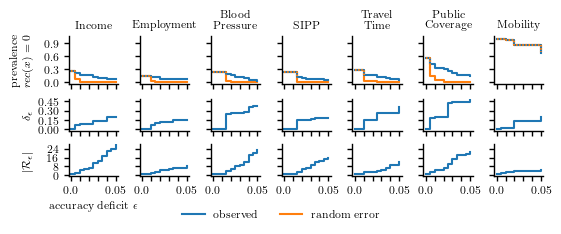

In [ ]:
tasks_to_plot = PAPER_TASKS 

measures = [
    "no_recourse",
    # "ambiguity",
    "discrepancy",
    "num_models",
]

fig_width = plt.rcParams["figure.figsize"][0]
fig_height = 0.7*plt.rcParams['figure.figsize'][1] #(1.6 if len(measures)==3 else 3)  # plt.rcParams['figure.figsize'][1]

fig, axs = plt.subplots(
    len(measures),
    len(tasks_to_plot),
    figsize=(fig_width, fig_height),
    constrained_layout=True,
    sharey="row",
    sharex=True,
    gridspec_kw={"height_ratios": [3, 2, 2]},
)


def plot_no_recourse(ax, data):
    x = np.array(data["eps"])
    y_rnd = np.array(data["random_error"]).squeeze()
    y_obs = np.array(data["observed"]).squeeze()
    ax.step(
        x,
        y_rnd,
        where="post",
        color="C1",
        label="random error",
    
    )
    ax.step(
        x,
        y_obs,
        where="post",
        color="C0",
        label="observed"
    )
    # plot rnd where overlap
    overlap = np.abs(y_rnd - y_obs) < 0.02
    overlap = np.concatenate(([True], overlap[:-1])) #adjust for plotting
    ax.step(
        x[overlap],
        y_rnd[overlap],
        where="post",
        color="C1",
        linestyle=(0, (0.75,0.75))
    )
    ymin = min(y_rnd.min(), y_obs.min())
    ymax = max(y_rnd.max(), y_obs.max())
    return ymin, ymax


def plot_measure(ax, data, measure):
    ax.step(data["eps"], data[measure], where="post", color="C0")
    return min(data[measure]), max(data[measure])


for m, measure in enumerate(measures):
    ymin_all = 100
    ymax_all = 0
    for t, task in enumerate(tasks_to_plot):
        ax = axs[m, t]
        if len(no_recourse[task]) == 0:
            ax.set_axis_off()
            continue
        else:
            if measure == "no_recourse":
                ymin, ymax = plot_no_recourse(ax, no_recourse[task])
                ymin_all = min(ymin_all, ymin)
                ymax_all = max(ymax_all, ymax)
            else:
                ymin, ymax =  plot_measure(ax, multiplicity_measures[task], measure)
                ymin_all = min(ymin_all, ymin)
                ymax_all = max(ymax_all, ymax)
        if m == 0:
            # column titles
            ax.set_title(add_newline_camelcase(task.replace("ACS", "").replace("BRFSS", "").replace("_", "")))
    
    ylabels={"no_recourse": "prevalence\n" "$rec(x)=0$", "ambiguity":r'$\alpha_{\epsilon}$', "discrepancy":"$\delta_{\epsilon}$", 'num_models': "$|\mathcal{R_\epsilon}|$"}
    axs[m, 0].set_ylabel(ylabels.get(measure, measure))

axs[-1,0].set_xlabel(r"accuracy deficit $\epsilon$")
xticks = no_recourse[task]['eps'][::2]

for ax in axs.flat:
    ax.yaxis.set_major_locator(ticker.MaxNLocator(nbins=4, prune=None))
    ax.set_xticks(xticks, labels = [xticks[0]] + ['']*(len(xticks)-2) + [xticks[-1]])
fig.align_ylabels(axs[:, 0])
 
configure_legend(fig, axs, offset= 0.18, add_monoculture_mixed_handle=False)
file_name = build_filename('no-recourse-multiplicity') #-full')

for ending in [".svg", ".pdf"]:
    plt.savefig(FIGURES_PAPER_DIR / f"fig3_{file_name}{ending}")
print(file_name)

plt.show()

recourse-epsilon-vals-0-shot_selected_by-accuracy_tresh_fitted-balanced-accuracy_pos_instances


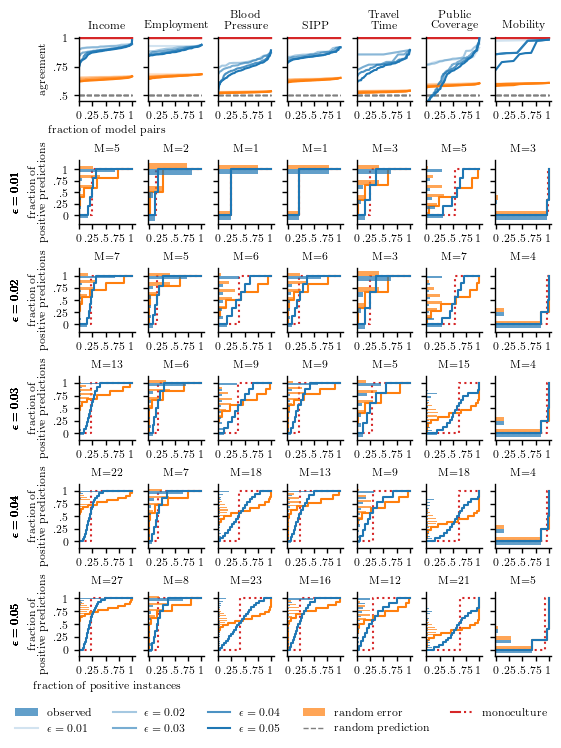

In [13]:
fig_width = plt.rcParams["figure.figsize"][0]
fig_height = 2.3*plt.rcParams['figure.figsize'][1] #(1.6 if len(measures)==3 else 3)  # plt.rcParams['figure.figsize'][1]

fig, axs = plt.subplots(
    6,
    len(tasks_to_plot),
    figsize=(fig_width, fig_height),
    constrained_layout=True,
    sharey="row",
    sharex=False,
    # gridspec_kw={"height_ratios": [1, 2,2,2,2,2]},
)
# share x manually between recourse plots
ref_ax = axs[1,0]
for row in range(1, 6):
    for col in range(7):
        axs[row, col].sharex(ref_ax)



for j, task in enumerate(tasks_to_plot):
    eps_vals = sorted(agreement_data[task].keys())[::2][1:]
    M = no_recourse[task]['num_models'][::2][1:]
    for i, eps in enumerate(eps_vals):
        axs[0,j] = plot_agreement_lineplot(
            ax=axs[0,j],
            curves=agreement_data[task][eps],
            ylim=(0.45, 1.0),
            xlabel='',
            ylabel='',
            title = f"{add_newline_camelcase(task.replace('ACS', '').replace('BRFSS', '').replace('_', ''))}",
            obs_alpha = 0.2*(i+1),
            baseline_alpha = 0.2*(i+1),
            fill_area_to_monoc = False, 
            obs_label = rf"$\epsilon={eps}$",
        )
        axs[i+1, j] = plot_recourse_lineplot(
            ax=axs[i+1, j],
            curves=recourse_curves[task][eps],
            num_models=M[i],
            xlabel='',
            ylabel='',
            title=f"M={M[i]}",
        )
        if j == 0:
            axs[i+1, j].set_ylabel("fraction of\n positive predictions")
        axs[i+1,0].annotate(
            rf"$\epsilon={eps}$",
            xy=(0, 0.5),
            xytext=(-axs[i+1,0].yaxis.labelpad-1, 0),
            xycoords=axs[i+1,0].yaxis.label,
            textcoords="offset points",
            size="small",
            ha="right",
            va="center",
            rotation=90,
        )
           
axs[0,0].set_ylabel('agreement')
axs[0,0].set_xlabel('fraction of model pairs')
axs[-1,0].set_xlabel('fraction of positive instances')
configure_legend(fig, axs, offset= 0.18, ncol = 5, order = ["observed"] + [rf"$\epsilon={eps}$" for eps in eps_vals] +[ "random error", "random prediction", "monoculture"])# ncol=1, loc='center left', bbox_to_anchor=(1, 0.85))
file_name = build_filename('recourse-epsilon-vals')

for ending in [".svg", ".pdf"]:
    plt.savefig(FIGURES_PAPER_DIR / f"{file_name}{ending}")
print(file_name)

plt.show()

In [14]:
# latex table
print(eps)
print(num_shots)
output = f"{'task':20} & M &\t {'ambiguity':12} & {'discrepancy':12}\\\\"
for task in tasks_to_plot:
    output +=  f"\n{task.replace('_', ' '):20} & {no_recourse[task]['num_models'][-1]} & \t{multiplicity_measures[task]['ambiguity'][-1]:.2f} & \t\t{multiplicity_measures[task]['discrepancy'][-1]:.2f}\\\\"
print(output)

with open(FIGURES_PAPER_DIR/ (build_filename('mulitiplicity_table')+'.txt'), "w") as file:
    file.write(output)

0.05
0
task                 & M &	 ambiguity    & discrepancy \\
ACSIncome            & 27 & 	0.43 & 		0.19\\
ACSEmployment        & 8 & 	0.30 & 		0.15\\
BRFSS Blood Pressure & 23 & 	0.83 & 		0.38\\
SIPP                 & 16 & 	0.47 & 		0.18\\
ACSTravelTime        & 12 & 	0.72 & 		0.35\\
ACSPublicCoverage    & 21 & 	0.86 & 		0.47\\
ACSMobility          & 5 & 	0.32 & 		0.20\\
